<center>
</center>


#  Береги уровень значимости с молоду 

В этой тетрадке мы будем работать с данными про Баскетбол. 

In [766]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")
from statsmodels.sandbox.stats.multicomp import multipletests 

plt.style.use('ggplot')
%matplotlib inline

COLLAB = False

In [732]:
if COLLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    df = pd.read_csv('/content/gdrive/MyDrive/DA/6/basketball.tsv', sep='\t')
else:
    df = pd.read_csv('basketball.tsv', sep='\t')
print(df.shape)
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(618019, 13)


,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,command,is_home
0,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,LAL,False
1,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,LAL,False
2,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,1,7:26,LAL,False
3,106 - 114,PHX - LAL,261031013.0,1.0,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18 - 12,2006 - 2007,0,7:26,LAL,False
4,106 - 114,PHX - LAL,261031013.0,1.0,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21 - 12,2006 - 2007,1,7:18,PHX,True


В файле `basketball.tsv` лежит [статистика о штрафных бросках в играх в Баскетбол, собранная с сайта ESPN.com](https://www.kaggle.com/sebastianmantey/nba-free-throws)

__Описание колонок:__

* `end_result` - результат игры
* `game` - какие команды играли, команда справа - хозяин площадки
* `game_id` - уникальный id игры
* `period` - период
* `player` - имя игрока
* `playoff` - тип игры
* `score` - счёт после броска 
* `season` - сезон игры
* `shot_made` - попал или не попал в кольцо при броске 
* `time` - время броска 
* `command` - предполагаемая команда игрока (колонка рассчитана по датасету)
* `is_home` - домашний матч или в гостях

# 1. Доля попаданий в корзину

Немного посмотрим на наши данные. Ответьте на следующие вопросы и запишите ответы в соотвествующие переменные. 

Сколько уникальных игр было сыграно в течение всего периода, который есть в таблице (`ans1`)? Сколько в данных встречается уникальных игроков (`ans2`)?

In [733]:
ans1 = df['game_id'].unique().size
ans2 = df['player'].unique().size

In [734]:
# проверка того, что задание решено верно
assert ans1 == 12874

Подсчитайте по каждому игроку статистику, связанную с тем, как часто он попадет в корзину при бросках:

- Долю попаданий в корзину среди его бросков, $\hat{p}$
- Число бросков, которое было сделано игроком, $n$

Среди игроков, которые сделали более ста бросков, найдите самого успешного. Запишите его в переменную `ans3`.

In [735]:
aggregation_functions = {'shot_made':['sum', 'count']}
df_new = df.groupby(df['player']).aggregate(aggregation_functions).reset_index()
df_new.columns = ["player","sum", "count"]
df_new["freak"] = df_new['sum']/df_new['count']
df_new.head()

,player,sum,count,freak
0,A.J. Price,211,282,0.748227
1,Aaron Brooks,928,1109,0.836790
2,Aaron Gordon,173,254,0.681102
3,Aaron Gray,189,339,0.557522
4,Aaron Harrison,5,12,0.416667


In [736]:
best_player = df_new[df_new['freak'] == df_new[df_new["count"] > 100]["freak"].max()]['player'].values[0]
ans3 = best_player
print("ans3 =", ans3)

ans3 = Steve Nash


In [737]:
# проверка того, что задание решено верно
assert ans3.split(' ')[0][-1] == 'e'
assert len(ans3.split(' ')[0]) == 5

Для поиска `ans4` и `ans5` используйте данные по игрокам, сделавшим более ста бросков.  

Найдите медиану распределения доли попаданий, запишите её в переменную `ans4`. Найдите значение коэффициента асимметрии, запишите его в переменную `ans5`. Какое значение он принимает? Правда ли, что распределение этой переменной оказывается скошенным?

Постройте гистограмму для доли попаданий игроков, нарисуйте на ней пунктирной линией медиану. Проинтерпретируйте то, что вы видите на рисунке.  

In [738]:
ans4 = df_new[df_new["count"] > 100]["freak"].median()
ans5 = sts.skew(df_new[df_new["count"] > 100]["freak"])
print("ans4 =", ans4)
print("ans5 =", ans5)

ans4 = 0.7568223240234471
ans5 = -1.037195664364386


**ОТВЕТ:** Коэффициент ассиметрии отрицательный, что означает, что среднее значение лежит левее медианы, распределение скошено влево.

In [739]:
# проверка того, что задание решено верно
assert ans4 > 0.7
assert ans5 < -1

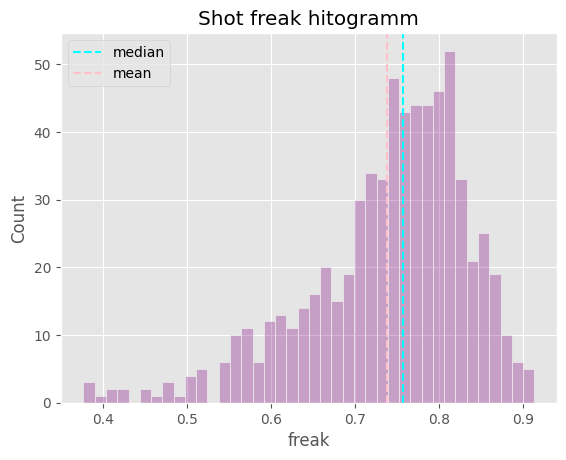

In [740]:
ax = sns.histplot(df_new[df_new["count"] > 100]["freak"], alpha=0.3, bins=40, color="purple")
ax.axvline(x = ans4, ymin = 0, ymax = 60, color="cyan", linestyle = "dashed", label="median")
ax.axvline(x = df_new[df_new["count"] > 100]["freak"].mean() , ymin = 0, ymax = 60, color="pink", linestyle = "dashed", label="mean")
ax.set(title = "Shot freak hitogramm")
ax.legend()
plt.show()

# 2. Игры дома и в гостях

Проанализируем, как часто игроки попадают в корзину дома и как часто в гостях. Подсчитайте доли попаданий в корзину в гостях и дома для всех ироков из выборки. Если для какого-то игрока оказывается, что он всегда играл только дома/только в гостях, удалите его из выборки.

Проверьте гипотезу о равенстве этих долей для каждого игрока против двусторонней альтернативы. Число гипотез, которые отклоняются на уровне значимости $5\%$,  запишите в переменную `ans6`. 

In [741]:
aggregation_functions = {'shot_made':['sum', 'count']}
df_new = df.groupby(['player','is_home']).aggregate(aggregation_functions).reset_index()
df_new.columns = ["player","is_home","sum", "count"]
df_new["freak"] = df_new['sum']/df_new['count']
df_new.head(6)

,player,is_home,sum,count,freak
0,A.J. Price,False,115,150,0.766667
1,A.J. Price,True,96,132,0.727273
2,Aaron Brooks,False,474,572,0.828671
3,Aaron Brooks,True,454,537,0.845438
4,Aaron Gordon,False,92,134,0.686567
5,Aaron Gordon,True,81,120,0.675000


In [742]:
one_type = df_new.groupby('player')['is_home'].count().reset_index()
one_type = one_type[one_type['is_home'] == 1]["player"].values

df_new = df_new.query("player not in @one_type").reset_index(drop=True)
df_new.head(6)

,player,is_home,sum,count,freak
0,A.J. Price,False,115,150,0.766667
1,A.J. Price,True,96,132,0.727273
2,Aaron Brooks,False,474,572,0.828671
3,Aaron Brooks,True,454,537,0.845438
4,Aaron Gordon,False,92,134,0.686567
5,Aaron Gordon,True,81,120,0.675000


$$
\text{Проверяем столько гипотез, сколько у нас различных игроков. Для каждого рассматриваем:}\\
\hspace{2mm}\\
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{Доли попаданий для игрока дома и не дома равны}\\
&H_1: \hspace{2mm} p_1 \ne p_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

In [743]:
alpha = 0.05

for player in (df_new['player'].unique()):
    by_player = df_new[df_new['player'] == player].sort_values('is_home')
    ztest = proportions_ztest((by_player['sum'].values), (by_player['count'].values), value=0, alternative = "two-sided")
    df_new.loc[df_new['player'] == player, 'pvalue'] = ztest[1]

df_new = df_new.dropna()
df_new['ztest'] = df_new['pvalue'] < alpha
ans6 = df_new.drop_duplicates(subset=['player'])['ztest'].sum()
print("ans6 =", ans6)

ans6 = 70


**ОТВЕТ:** Для 70 гипотез pvalue ниже уровня значимости 5%, для них гипотезы  о равенстве доли попаданий дома и на выезде отвергаются.

In [744]:
# проверка того, что задание решено верно
assert ans6 < 100
assert ans6 > 60

Введите коррекцию с помощью метода Холма. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans7`.

In [745]:
holm = multipletests(df_new['pvalue'], alpha = alpha, method = 'holm')
df_new['holm'] = holm[1] < alpha
ans7 = df_new.drop_duplicates(subset=['player'])['holm'].sum()
print("ans7 =", ans7)

ans7 = 0


Введите коррекцию с помощью метода Бенжамини-Хохберга. Запишите число гипотез, которые были отклонены на уровне значимости $5\%$, в переменную `ans8`.

In [746]:
fdr_bh = multipletests(df_new['pvalue'], alpha = alpha, method = 'fdr_bh')
df_new['fdr_bh'] = holm[1] < alpha
ans8 = df_new['fdr_bh'].sum()
print("ans8 =", ans8)

ans8 = 0


In [747]:
# проверка того, что задание решено верно
assert ans7 < 10
assert ans8 < 10

Объясните разницу, которую вы получили в количестве отклоненных гипотез. Предположим, что вы менеджер команды и вы хотите на основе статистики принять решение о том, какие игроки должны играть на поле в домашнем матче. Как вы будете его принимать? 

___________________________________

**ОТВЕТ:** При однократной проверке гипотез всегда есть вероятность совершить ошибку первого или второго рода. При этом вероятность ошибки первого рода (вероятность ложно отвергнуть верную нулевую гипотезу) ограничена сверху уровнем значимости alpha. В случае множественной проверки гипотез мы снижаем вероятность совершить ошибку первого рода при помощи корректировки уровня значимости.

В методе Холма контролируется ограничивается вероятность совершить хотя бы одну ошибку первого рода, а в метод Бенджамина - Хохберга дает возможность совершить какое-то количество ошибок первого рода ради того, чтобы совершить меньше ошибок второго рода.

Для менеджера хуже ситуация, когда принята неверная нулевая гипотеза, т.е. совершена ошибка второго рода. Для рассмотрения игроков на домашний матч я бы выбрала игроков с наибольшим числом бросков, для которым соответствует наибольшая точность, гипотезы о которых не отверг метод Бенджамина - Хохберга.
________________________________

Отсортируйте таблицу по `pvalue`, полученному из самого первого теста. Посмотрите на самые большие и самые маленькие значения. Какое число наблюдений им соотвествуте? Как думаете, почему гипотезы для маленького числа наблюдений не отвергаются? Как это связано с ЗБЧ? Можно ли доверять этим результатам? Как их можно было бы решить при предобработке данных? 

In [748]:
df_new[['player','pvalue', "sum", "count"]].sort_values('pvalue', ascending=False).dropna()

,player,pvalue,sum,count
1406,Mickell Gladness,1.00000,2,4
378,Cristiano Felicio,1.00000,10,14
1323,Marcus Vinicius,1.00000,5,9
1350,Marshon Brooks,1.00000,10,12
1351,Marshon Brooks,1.00000,5,6
...,...,...,...,...
827,Jamario Moon,0.00070,70,101
91,Andrew Bogut,0.00066,300,612
90,Andrew Bogut,0.00066,419,718
811,Jahlil Okafor,0.00063,83,105


___________________________________

**ОТВЕТ:** Самым большим значениям pvalue  соответствует малое количество наблюдений, и наоборот. 
При использовании восходящей процедуры движение происходит от
самого большого p-value к самому маленькому, если используется нисходящая процедура, то наоборот, всё начинается с самого маленького p-value, но при этом во всех методах коррекции самый малый p_value сравнивается с alpha/m.

Необходимо на этапе предобработки данных удалить данные не только с общим числом бросков < 100, но и с числом бросков по каждому виду is_home меньше заранее заданного значения, таким образом мы сокращаем число гипотез, делаем более точным значение pvalue и имеем лучшую методику множественной проверки гипотез.
________________________________

# 3. Постоянство - признак мастерства

__Решение задач из этого пункта является не обязательным и никак не влияет на вашу оценку.__ 

В наших данных есть несколько сезонов. Постройте гистограмму с распределением числа игр по каждому году. Видна ли на гистограмме [аномалия, произошедшая в $2011$ году?](https://en.wikipedia.org/wiki/2011_NBA_lockout) 

,season,count
0,2006 - 2007,67612
1,2007 - 2008,65500
2,2008 - 2009,65355
3,2009 - 2010,64804
4,2010 - 2011,64137
5,2011 - 2012,48459
6,2012 - 2013,58376
7,2013 - 2014,62290
8,2014 - 2015,60131
9,2015 - 2016,61355


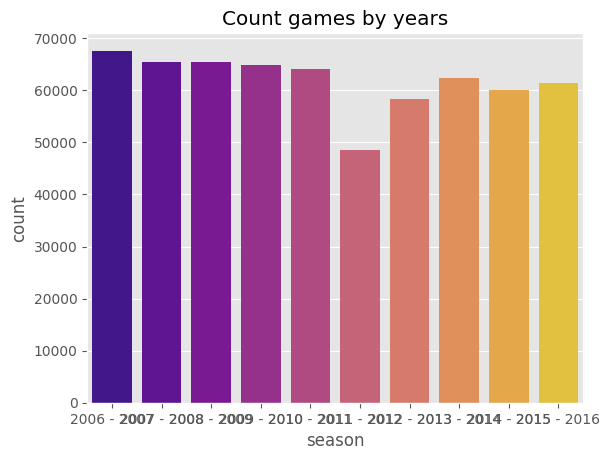

In [749]:
display(df.groupby(["season"])["game_id"].agg(['count']).reset_index())
season_df = df.groupby(["season"])["game_id"].agg(['count']).reset_index()
sns.barplot(x="season", y="count", data=season_df,palette = "plasma").set(title="Count games by years")
plt.show()

- Посчитайте для каждого игрока по каждому сезону долю попаданий в кольцо и количество сделанных бросков. 
- Оставьте в данных только те строки, где было сделано как минимум сто бросков. Удалите колонку с количеством сделанных бросков. 
- Методом `unstack("player")` вытащите индексы, отвечающие в группировке за игроков в названия столбцов. Методом `droplevel()` удалите все лишние заголовки таблицы.
- Удалите из данных всех игроков, у которых пропущена статистика хотя бы по одному сезону.

In [750]:
df_new = df.groupby(['player',"season"])['shot_made'].agg(['count', 'sum']).reset_index()
df_new['freak'] = df_new["sum"] / df_new["count"]
df_new = df_new[df_new["count"] > 100]
seasons = set(df_new['season'].unique())
players = df_new['player'].unique()

df_new = df_new[df_new['player'] != player]
for player in players:
    if set(df_new[df_new['player'] == player]['season'].unique()) != seasons:
        df_new = df_new[df_new['player'] != player] 
df_new = df_new.drop(columns=["count", "sum"]).reset_index(drop = True)     
display(df_new)

,player,season,freak
0,Al Jefferson,2006 - 2007,0.681356
1,Al Jefferson,2007 - 2008,0.720812
2,Al Jefferson,2008 - 2009,0.738095
3,Al Jefferson,2009 - 2010,0.680451
4,Al Jefferson,2010 - 2011,0.759582
...,...,...,...
265,Zaza Pachulia,2011 - 2012,0.740506
266,Zaza Pachulia,2012 - 2013,0.757282
267,Zaza Pachulia,2013 - 2014,0.846154
268,Zaza Pachulia,2014 - 2015,0.774566


In [751]:
#assert shooting_per_season.shape == (10, 27)

Посчтитайте для всех игроков стандартное отклонение их доли попаданий в динамике по сезонам. 

In [752]:
std_per_player = {}
for player in df_new['player'].unique():
    std_per_player[player] = df_new[df_new['player'] == player]['freak'].std()

std_per_player = pd.DataFrame.from_dict(std_per_player, orient='index')
std_per_player = std_per_player.reset_index().rename(columns={"index": "player", 0: "freak std"})
std_per_player = std_per_player.sort_values(by = "freak std").reset_index(drop = True)
display(std_per_player)

,player,freak std
0,Luol Deng,0.014586
1,Kevin Martin,0.015665
2,Dirk Nowitzki,0.016183
3,Jarrett Jack,0.019644
4,Dwyane Wade,0.020733
5,Chris Bosh,0.020911
6,Carmelo Anthony,0.022007
7,LeBron James,0.025669
8,Jamal Crawford,0.027020
9,Chris Paul,0.027927


**ОТВЕТ:** Игроки с наименьшим стандартным отклонением наиболее предсказуемы, с наибольшим менее.

Постройте для $3$ самых непредсказуемых игроков и для трёх самых предсказуемых игроков динамику доли их попаданий по сезонам (по оси $x$ сезоны, по оси $y$ доля попаданий). 

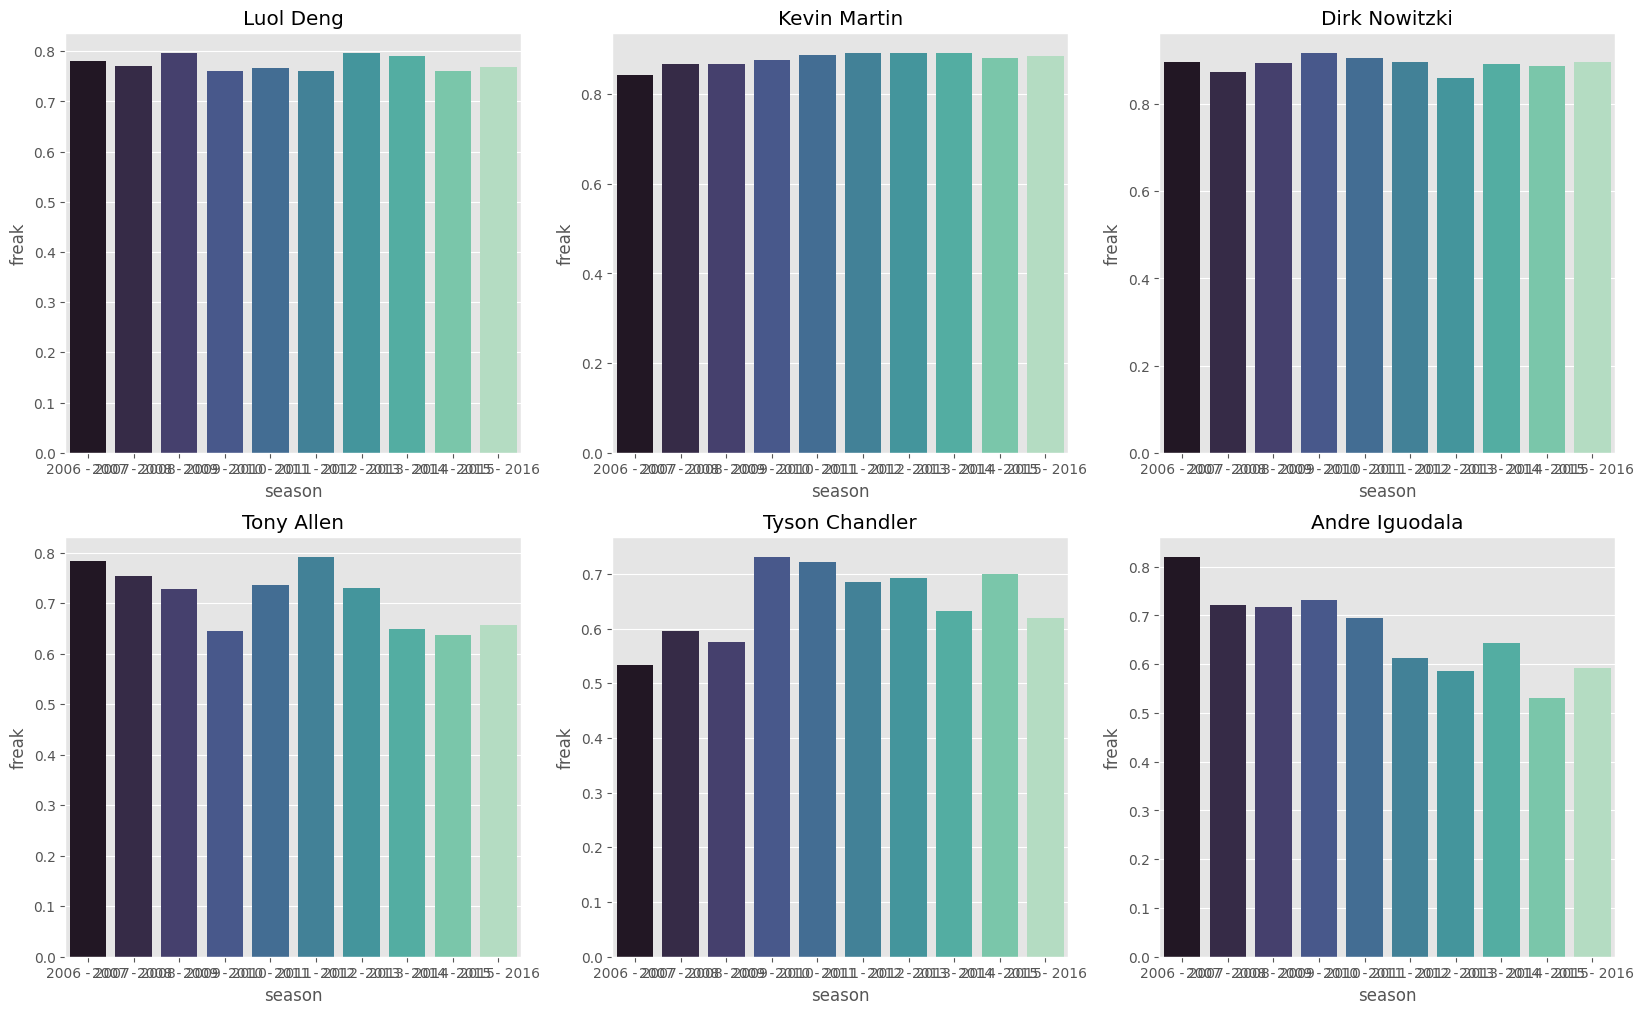

In [753]:
stable = ["Luol Deng","Kevin Martin","Dirk Nowitzki"]
unstable = ["Tony Allen", "Tyson Chandler", "Andre Iguodala"]
players = [stable, unstable]

fig, axes = plt.subplots(2,3, figsize = (20,12))

for i, stab_type in enumerate(players):
    for j, player in enumerate(stab_type):
        sns.barplot(x="season",
                    y="freak",
                    data = df_new[df_new['player'] == player],
                    ax = axes[i][j],
                    palette = "mako").set(title=player)


Каких игроков из представленных вы бы предпочли взять к себе в команду? Кому бы вы предпочли доверить делать штрафные броски? Почему? 

___________________________________

**ОТВЕТ:** Я бы привлекла в команду игроков с наибольшей стабильностью или с нарастающей точностью к последнему сезону. Самый лучший вариант Kewin Martin, самый худший Andre Iguodala
_______________________


# 4. Эффект победителя

__Решение задач из этого пункта является не обязательным и никак не влияет на вашу оценку.__ 

__Гипотеза:__

> Если мы попали в корзину, сделав первый штрафной бросок, вероятность попасть при втором штрафном выше, чем если бы мы промахнулись.

Проверим эту гипотезу. 

- Создадим в исходной таблице колонку `shot_made_previous` методом `shift()`. В ней будет записан результат предыдущего броска. Данные отсортированы по времени.
- Извлечём из данных в таблицу `winner_effect` все строки, где в колонке `play` находится одна из записей: `"2 of 2", "2 of 3", "3 of 3"`. Каждая из них означает, что предыдущий бросок был сделан успешно. Этот же срез выбросит из таблицы все строки, где сдвиг, сделанный в предыдущем пункте, привёл к появлению некорректных записей.  

In [754]:
df["shot_made_previous"] = df.shot_made.shift()

winner_effect = df[(df.play.str.contains("2 of 2")) | \
                   (df.play.str.contains("2 of 3")) | 
                   (df.play.str.contains("3 of 3"))]

По аналогии с пунктом $2$ найдите вероятность попасть в корзину при условии, что первый бросок был успешен, и вероятность попасть, при условии, что первый бросок был неуспешен. 

- Всех игроков с оценкой только одной из вероятностей удалите из данных.
- Всех игроков, у которых было меньше $10$ успешных первых бросков либо проваленных первых бросков, также удалите.

Для каждого игрока проверьте гипотезу о том, что эти две вероятности совпадают. Используйте уровень значимости $5\%$. Для коррекции уровня значимости используйте методы Холма и Бенжамини-Хохберга. Для скольких игроков гипотеза об эффекте победителя не отвергается?

In [755]:
winner_effect.head()
df_new = winner_effect[:][['player','shot_made','shot_made_previous']]
df_new.head()

,player,shot_made,shot_made_previous
1,Andrew Bynum,1,1.0
3,Andrew Bynum,0,1.0
6,Amare Stoudemire,1,1.0
8,Leandro Barbosa,1,0.0
10,Lamar Odom,1,1.0


In [756]:
aggregation_functions = {'shot_made':'count' }
df_group = df_new.groupby(['player','shot_made_previous','shot_made']).aggregate(aggregation_functions)
df_group.columns = ["shot_made_count"]
display(df_group.head())
df_group.shape

shot_made_count
player       shot_made_previous shot_made                 
A.J. Price   0.0                0                        9
                                1                       22
             1.0                0                       19
                                1                       73
Aaron Brooks 0.0                0                       16

(3989, 1)

In [757]:
df_group = df_group.reset_index(level=["player", 'shot_made_previous', "shot_made"])


In [758]:
for player in df_group["player"].unique():
    for shot in df_group['shot_made'].unique():
        if df_group[(df_group["player"] == player) & (df_group["shot_made"] == shot)]["shot_made_count"].sum() < 10:
            df_group = df_group[df_group["player"] != player]

In [759]:
for player in df_group["player"].unique():
    if df_group[df_group["player"]==player]['player'].count() < 4:
        df_group = df_group[df_group["player"] != player]
print(df_group.shape)

(2776, 4)


In [760]:
df_group.head(8)

,player,shot_made_previous,shot_made,shot_made_count
0,A.J. Price,0.0,0,9
1,A.J. Price,0.0,1,22
2,A.J. Price,1.0,0,19
3,A.J. Price,1.0,1,73
4,Aaron Brooks,0.0,0,16
5,Aaron Brooks,0.0,1,82
6,Aaron Brooks,1.0,0,55
7,Aaron Brooks,1.0,1,343


In [761]:
probability = np.array([])
count = np.array([])
for player in df_group["player"].unique():
    for shot in df_group['shot_made_previous'].unique():
        table = df_group[(df_group["player"] == player) & (df_group['shot_made_previous'] == shot)]
        count = np.hstack((count, np.array([table['shot_made_count'].sum()]*2)))
        probability = np.hstack((probability, (table['shot_made_count'] / table['shot_made_count'].sum()).values))
df_group['count'] = count
df_group['probability'] = probability


In [762]:
df_group = df_group[df_group['shot_made'] != 0]
df_group.head()

,player,shot_made_previous,shot_made,shot_made_count,count,probability
1,A.J. Price,0.0,1,22,31.0,0.709677
3,A.J. Price,1.0,1,73,92.0,0.793478
5,Aaron Brooks,0.0,1,82,98.0,0.836735
7,Aaron Brooks,1.0,1,343,398.0,0.861809
9,Aaron Gordon,0.0,1,27,38.0,0.710526


$$
\text{Проверяем столько гипотез, сколько у нас различных игроков. Для каждого рассматриваем:}\\
\hspace{2mm}\\
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{Вероятности попаданий для игрока после удачного и неудачного броска равны}\\
&H_1: \hspace{2mm} p_1 \ne p_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

In [763]:
alpha = 0.05

for player in (df_group['player'].unique()):
    by_player = df_group[df_group['player'] == player].sort_values('shot_made_previous')
    ztest = proportions_ztest((by_player['shot_made_count'].values), (by_player['count'].values), value=0, alternative = "two-sided")
    df_group.loc[df_group['player'] == player, 'pvalue'] = ztest[1]

df_group['ztest'] = df_group['pvalue'] > alpha
print(df_group.drop_duplicates(subset=['player'])['ztest'].sum())

640


In [764]:
holm = multipletests(df_group['pvalue'], alpha = alpha, method = 'holm')
df_group['holm'] = holm[1] > alpha
print(df_group.drop_duplicates(subset=['player'])['holm'].sum())

694


In [765]:
fdr_bh = multipletests(df_group['pvalue'], alpha = alpha, method = 'fdr_bh')
df_group['fdr_bh'] = holm[1] > alpha
print(df_group['fdr_bh'].sum())

1388


Посмотрите на таблицу значимых по Бенжамини-Хохбергу эффектов. Какие из них на ваш взгляд являются существенными? Не допустили ли мы в этих ситуациях ошибку второго рода?

________________________________
Вот тут не поняла, как именно их посмотреть, к сожалению.
_____________________________